# Libraries

In [1]:
# # Run this code if you're using TPUv2-8 runtime
# !pip install yfinance statsmodels tensorflow==2.16.* keras-tuner -q

In [2]:
!pip install keras-tuner -q
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import urllib
import zipfile
import yfinance as yf
import os
import keras_tuner

from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Lambda, GRU, Dropout
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import files

2025-04-24 03:27:34.067005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745465254.291985      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745465254.359357      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print(tf.__version__)

2.18.0


# Utilities

In [5]:
# Plot series
def plot_series(df,
                columns,
                start_date=None,
                end_date=None,
                colors=['blue', 'red', 'green', 'brown'],
                fillbar=False
                ):
  """Plots multiple series from a Pandas DataFrame with different colors.

  Args:
    df: Pandas DataFrame containing the time series data.
    columns: A list of column names to plot.
    colors: A list of colors to use for each series.
  """
  # Ensure the DataFrame index is a DatetimeIndex
  if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.apply(lambda x : pd.to_datetime(x.index, format='%Y-%m-%d'))

  # plot start and end series time if defined, if not, use entire dataframe
  df = df.loc[start_date:end_date] if start_date and end_date else df

  # add columns and rows
  if len(columns) > 1:
    ncols=2
    # adjust rows based on number of columns
    nrows=math.ceil(len(columns) / ncols)
  else:
    ncols=1
    nrows=1

  fig, ax = plt.subplots(figsize=(16, 5*nrows), ncols=ncols, nrows=nrows)
  if len(columns) > 1:
    ax = ax.flatten()
  # Iterate over the columns and plot each one
    for i, column in enumerate(columns):
      if fillbar:
        ax[i].fill_between(df.index, df[column].min(), df[column], alpha=0.7, color=colors[i % len(colors)])
      ax[i].plot(df.index, df[column], color=colors[i % len(colors)], label=column)
      ax[i].set_title(column)
      ax[i].set_xlabel("Time")
      ax[i].set_ylabel("Price")
      ax[i].legend()
      ax[i].grid(True)
  else:
    if fillbar:
      ax.fill_between(df.index, df[columns[0]].min(), df[columns[0]], alpha=0.7)
    ax.plot(df.index, df[columns[0]], color=colors[0], label=columns[0])
    ax.set_title(columns[0])
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.show()


def plot_history(history):
  fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
  print(history.history.keys())

  params = history.history.keys()
  epochs = range(len(history.history['loss']))


  # Iterate over axes objects in the grid
   # Access and iterate over individual axes in the grid
  for i, param in enumerate(['loss', 'mae']):
    ax[i].set_title(param)
    ax[i].plot(epochs, history.history[param], label=param)
    ax[i].plot(epochs, history.history[f'val_{param}'], label=f'val_{param}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].grid(True)
    ax[i].legend()

  plt.show()

def plot_compare(df: pd.core.frame.DataFrame, 
                 columns: list, 
                 title: str = 'Value Comparasion',
                 save_fig: str = None,
                ):

    for col in columns:
        plt.plot(df[col], label=col)
        
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if save_fig != None:
        plt.savefig(save_fig)
    plt.show()

# Generate Data

## Extract data

---






This process of extracting data from yahoo finance using yfinance python library. The extacted dataset has been saved to the github account for fixed date range of dataset.
<br><br>
The Downloaded dataset then pushed into the github account for access it as public. <br> To access the dataset on github repository please visit this <a href="https://github.com/sayid-alt/usd_idr_exchange_prediction/tree/main/datasets">link<a/>.

In [6]:
# Declare IDR=X object
idrx = yf.Ticker("IDR=X")

# Retrieve Historical dataset
idrx_history = idrx.history(period="max") # period 5 years from the running code, it might changes overtime
idrx_history.sort_values(by='Date', ascending=True, inplace=True)
idrx_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-06-28 00:00:00+01:00,11441.000000,11565.000000,11338.000000,11448.000000,0,0.0,0.0
2001-06-29 00:00:00+01:00,11370.000000,11510.000000,11265.000000,11390.000000,0,0.0,0.0
2001-07-02 00:00:00+01:00,11315.000000,11490.000000,11215.000000,11320.000000,0,0.0,0.0
2001-07-03 00:00:00+01:00,11330.000000,11455.000000,11188.000000,11322.000000,0,0.0,0.0
2001-07-04 00:00:00+01:00,11355.000000,11465.000000,11251.000000,11365.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-16 00:00:00+01:00,16813.500000,16858.800781,16777.199219,16813.500000,0,0.0,0.0
2025-04-17 00:00:00+01:00,16794.599609,16876.599609,16793.900391,16794.599609,0,0.0,0.0
2025-04-22 00:00:00+01:00,16814.900391,16871.900391,16789.099609,16814.900391,0,0.0,0.0


In [7]:
idrx_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6006 entries, 2001-06-28 00:00:00+01:00 to 2025-04-24 00:00:00+01:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6006 non-null   float64
 1   High          6006 non-null   float64
 2   Low           6006 non-null   float64
 3   Close         6006 non-null   float64
 4   Volume        6006 non-null   int64  
 5   Dividends     6006 non-null   float64
 6   Stock Splits  6006 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 375.4 KB


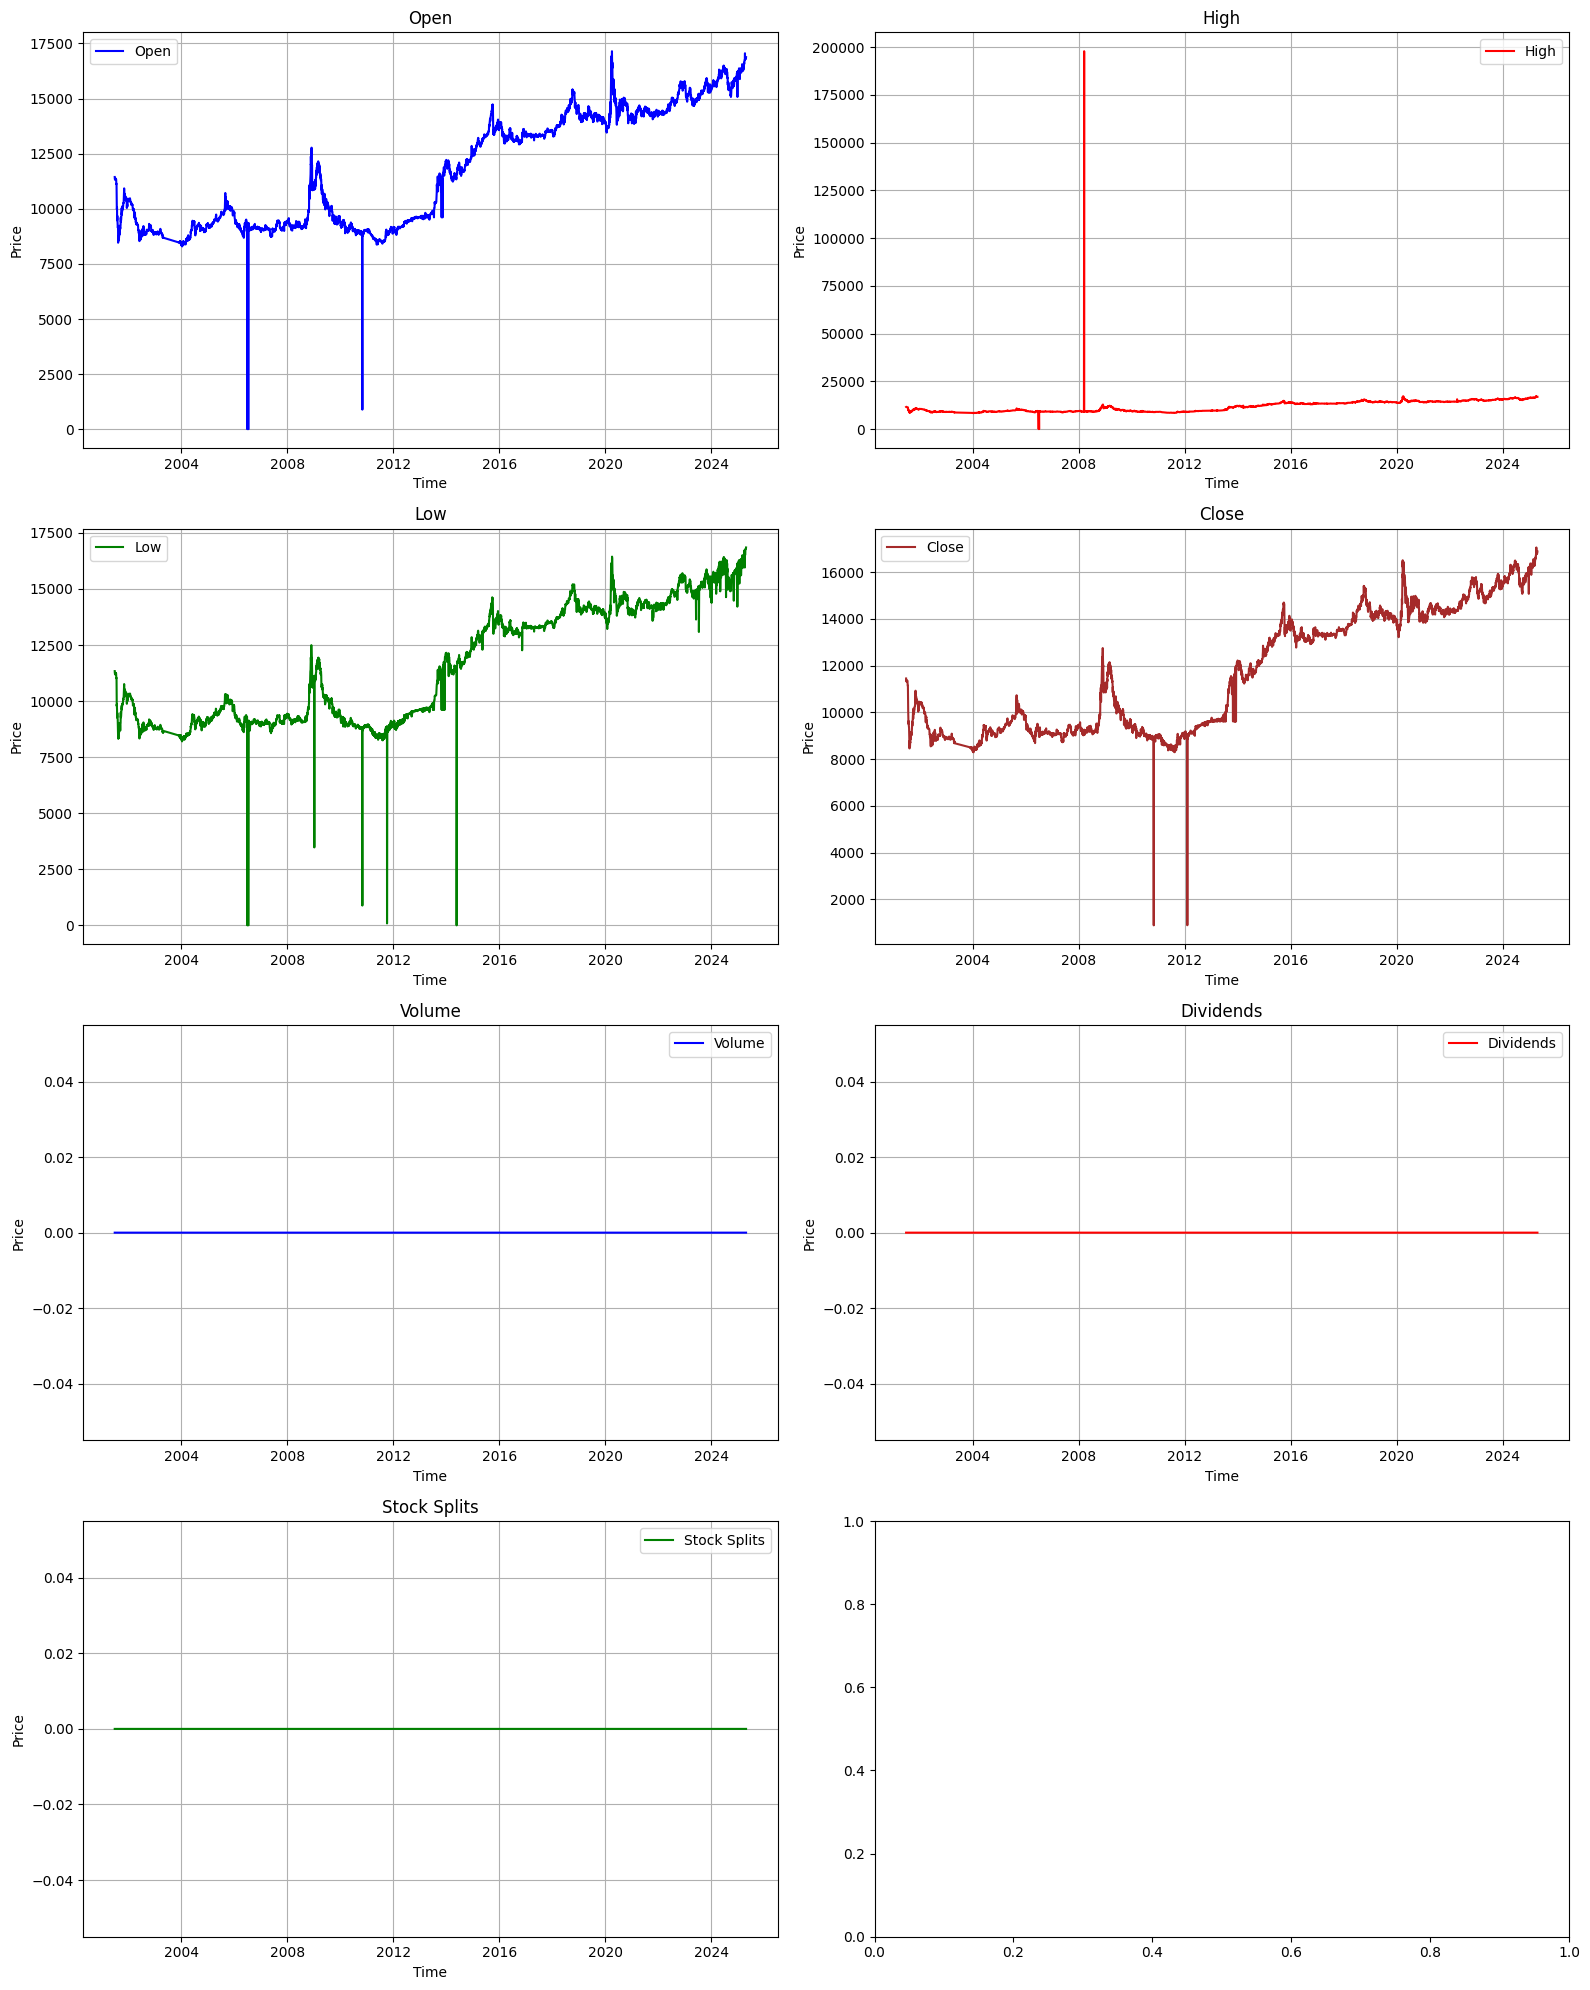

In [8]:
plot_series(idrx_history, columns=idrx_history.columns)

## Looking for 2002-2024 dataset range

In [9]:
idrx_2002_2024 = idrx_history.loc['2002-01-01':'2024-01-01']
idrx_2002_2024

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-02 00:00:00+00:00,10435.000000,10575.0,10295.000000,10415.000000,0,0.0,0.0
2002-01-03 00:00:00+00:00,10358.000000,10500.0,10258.000000,10375.000000,0,0.0,0.0
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0


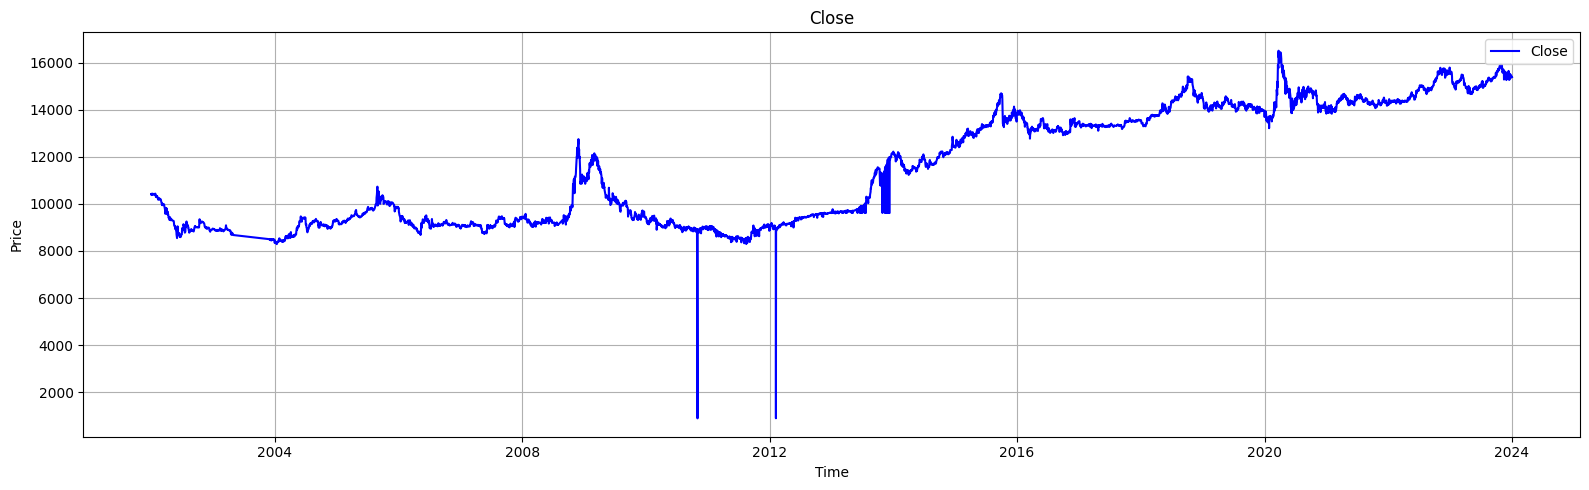

In [10]:
plot_series(idrx_2002_2024, columns=['Close'])

## Save loaded dataset to csv file

In [11]:
# save csv file
def save_csv(df, dir, download=False):
  '''
    All downloaded file will stored in download directory
  '''
  os.makedirs('download', exist_ok=True)
  print(f'Success make dir download')
  save_path = os.path.join('download', dir)
  df.to_csv(save_path)
  print(f'Success save {save_path} to /download{save_path}')

  if download:
    files.download(save_path)

# Uncomment code below for downloading the file
save_path = "usd_idr_historical_data_20y.csv"
# set download to False if you just want to save csv
save_csv(idrx_history, save_path, download=False)

Success make dir download
Success save download/usd_idr_historical_data_20y.csv to /downloaddownload/usd_idr_historical_data_20y.csv


## Load Dataset

In [12]:
dataset_path = '/kaggle/input/usd-idr-price-20y/usd_price_20y'
idrx_df = pd.read_csv(dataset_path, index_col='Date')
idrx_df.index = pd.to_datetime(idrx_df.index, utc=True)
idrx_df.index = pd.to_datetime(idrx_df.index.date)
# idrx_df.sort_values(by='Date', ascending=True, inplace=True)
idrx_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2002-01-02,10435.000000,10575.0,10295.000000,10415.000000,0,0.0,0.0
2002-01-03,10358.000000,10500.0,10258.000000,10375.000000,0,0.0,0.0
2002-01-04,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0
2002-01-07,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-08,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
2023-12-27,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-28,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0
2023-12-29,15425.000000,15536.5,14416.500000,15425.000000,0,0.0,0.0


In [13]:
idrx_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5542 entries, 2002-01-02 to 2024-01-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5542 non-null   float64
 1   High          5542 non-null   float64
 2   Low           5542 non-null   float64
 3   Close         5542 non-null   float64
 4   Volume        5542 non-null   int64  
 5   Dividends     5542 non-null   float64
 6   Stock Splits  5542 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 346.4 KB


In [14]:
for col in idrx_df.columns:
  print(f'{col}: {idrx_df[col].nunique()}')

Open: 4393
High: 4409
Low: 4177
Close: 4355
Volume: 1
Dividends: 1
Stock Splits: 1


`Volume`, `Dividends`, `Stock Splits` does not give much information, so we'll drop it

In [15]:
idrx_df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
idrx_df

,Open,High,Low,Close
2002-01-02,10435.000000,10575.0,10295.000000,10415.000000
2002-01-03,10358.000000,10500.0,10258.000000,10375.000000
2002-01-04,10428.000000,10600.0,10195.000000,10428.000000
2002-01-07,10390.000000,10528.0,10290.000000,10390.000000
2002-01-08,10423.000000,10523.0,10323.000000,10423.000000
...,...,...,...,...
2023-12-26,15460.000000,15460.0,15398.500000,15460.000000
2023-12-27,15400.000000,15434.0,15347.400391,15400.000000
2023-12-28,15373.000000,15443.0,15369.200195,15373.000000
2023-12-29,15425.000000,15536.5,14416.500000,15425.000000


Much better! :)

Now we'll look into the moving data point in each columns

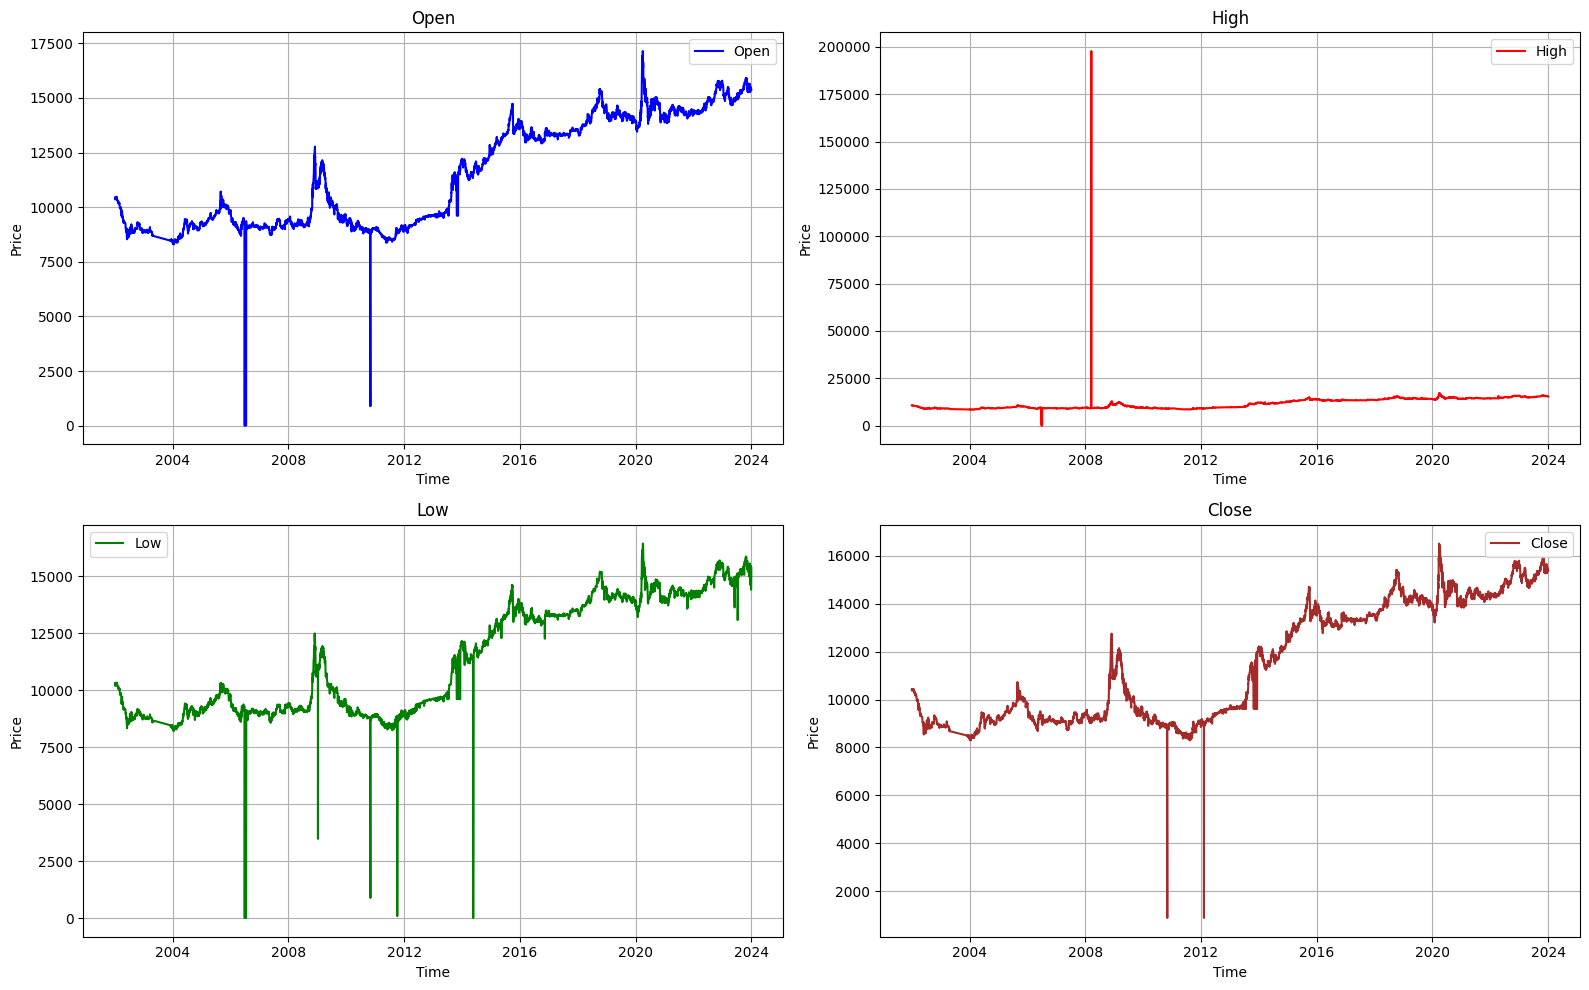

In [16]:
plot_series(idrx_df, columns=idrx_df.columns)

Looks there is outlier in value, and we should handle it later

# Preprocessing

## Check for missing value

In [17]:
idrx_df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

## Handling the outlier

As seen above, we found the outlier of the dataset, it'll make trained model not performing well. Now we'll look up the case. <br>
The oulier seems happened between 2010 and 2013. But there is different outlier in each columns. Instead, we're going to set the upper and lower bound, which will return value between 5000 and 30000

In [18]:
idrx_df = idrx_df[
    (idrx_df['Close'] > 5000) & (idrx_df['Close'] < 30000) &
     (idrx_df['Open'] > 5000) & (idrx_df['Open'] < 30000) &
      (idrx_df['High'] > 5000) & (idrx_df['High'] < 30000) &
       (idrx_df['Low'] > 5000) &(idrx_df['High'] < 30000)
       ]
idrx_df

,Open,High,Low,Close
2002-01-02,10435.000000,10575.0,10295.000000,10415.000000
2002-01-03,10358.000000,10500.0,10258.000000,10375.000000
2002-01-04,10428.000000,10600.0,10195.000000,10428.000000
2002-01-07,10390.000000,10528.0,10290.000000,10390.000000
2002-01-08,10423.000000,10523.0,10323.000000,10423.000000
...,...,...,...,...
2023-12-26,15460.000000,15460.0,15398.500000,15460.000000
2023-12-27,15400.000000,15434.0,15347.400391,15400.000000
2023-12-28,15373.000000,15443.0,15369.200195,15373.000000
2023-12-29,15425.000000,15536.5,14416.500000,15425.000000


DONE! <br>
Now if we plot the chart again.

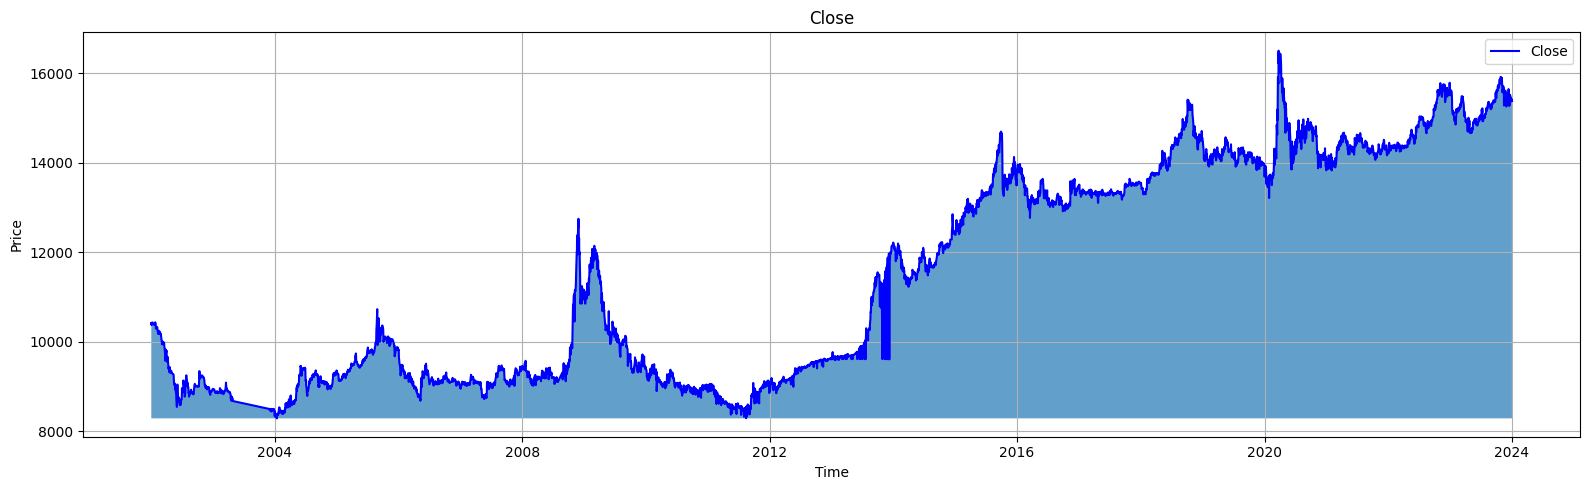

In [19]:
plot_series(idrx_df, columns=['Close'], fillbar=True)

Looks better! And now can we see the significant change of price rate from 2002 to 2024


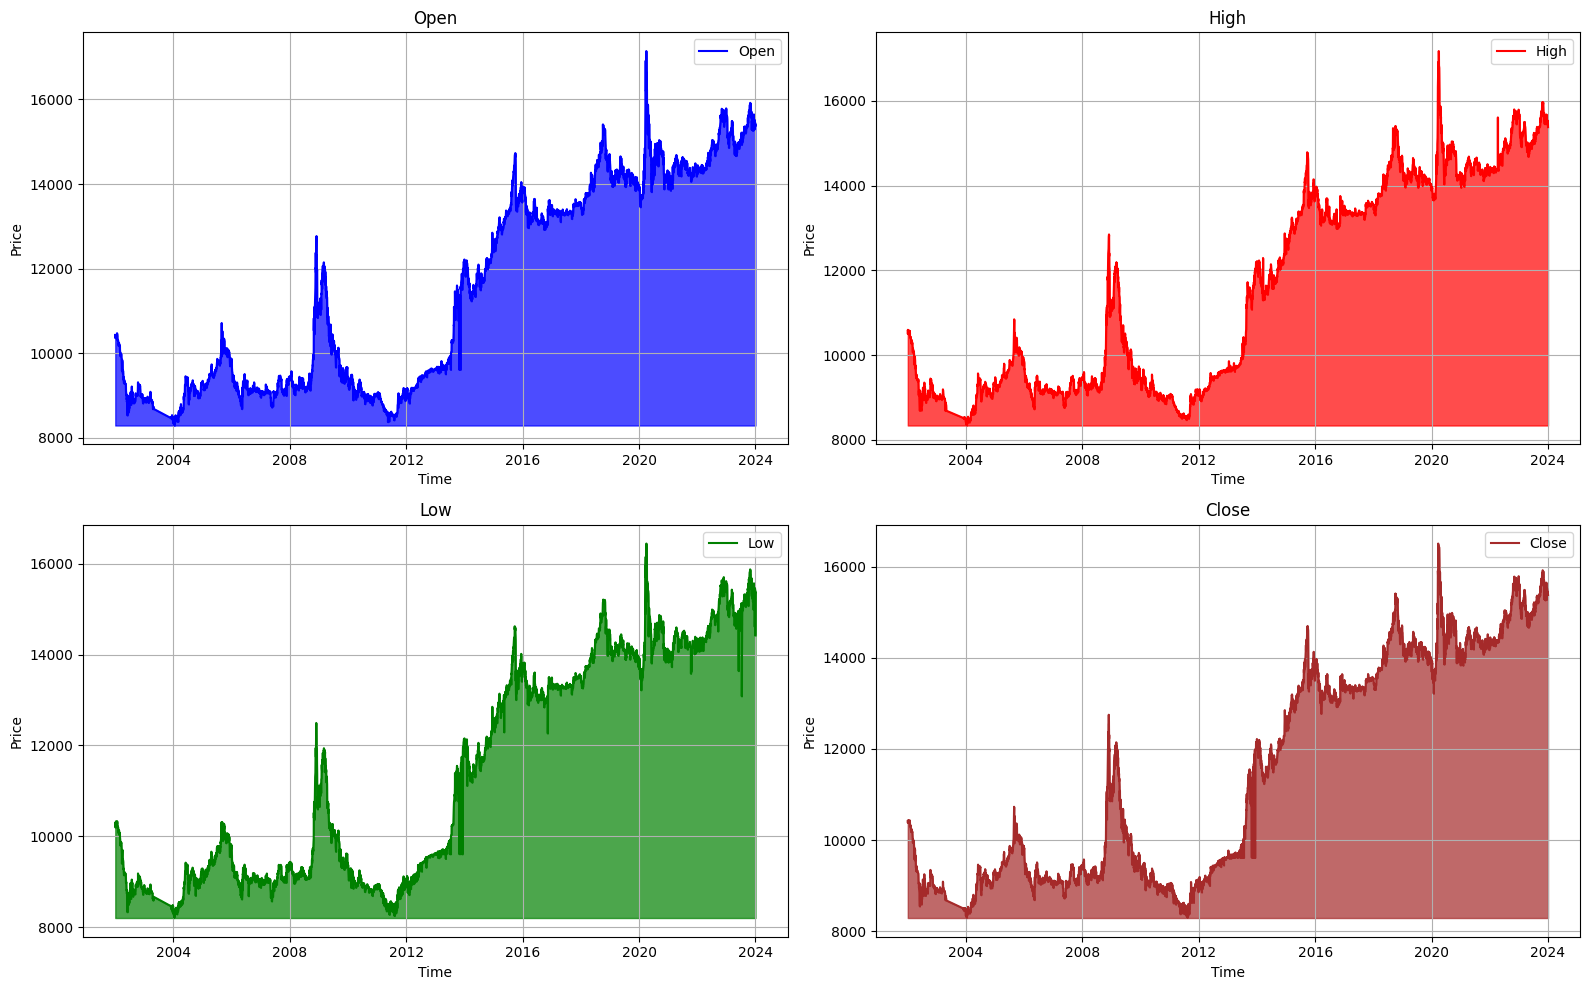

In [20]:
plot_series(idrx_df, columns=idrx_df.columns, fillbar=True)

Now they're looks cleaner

## Split data

Here we're going to split the dataset into train and valid dataset. Where each will be differenced dataset (stationary) and original dataset (non-stationary), which both would be trained and compared their accuracy to receive a better model

In [21]:
split_time = int(len(idrx_df) * 0.2)
train_series = idrx_df[:-split_time]
valid_series = idrx_df[-split_time:]

### train test series

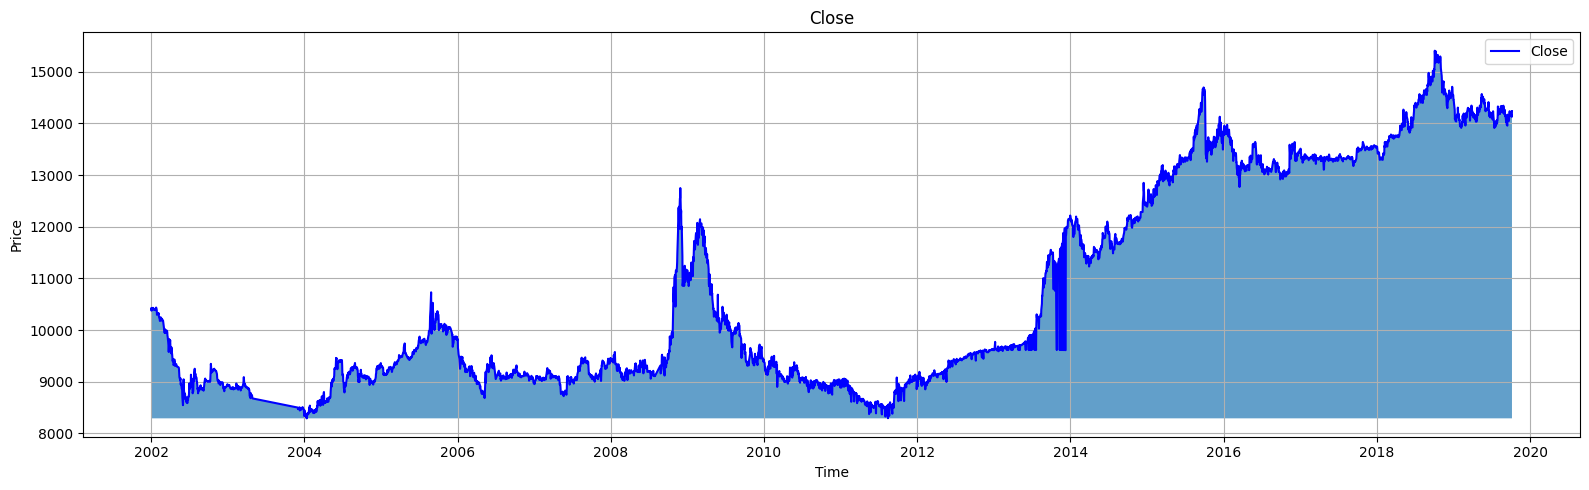

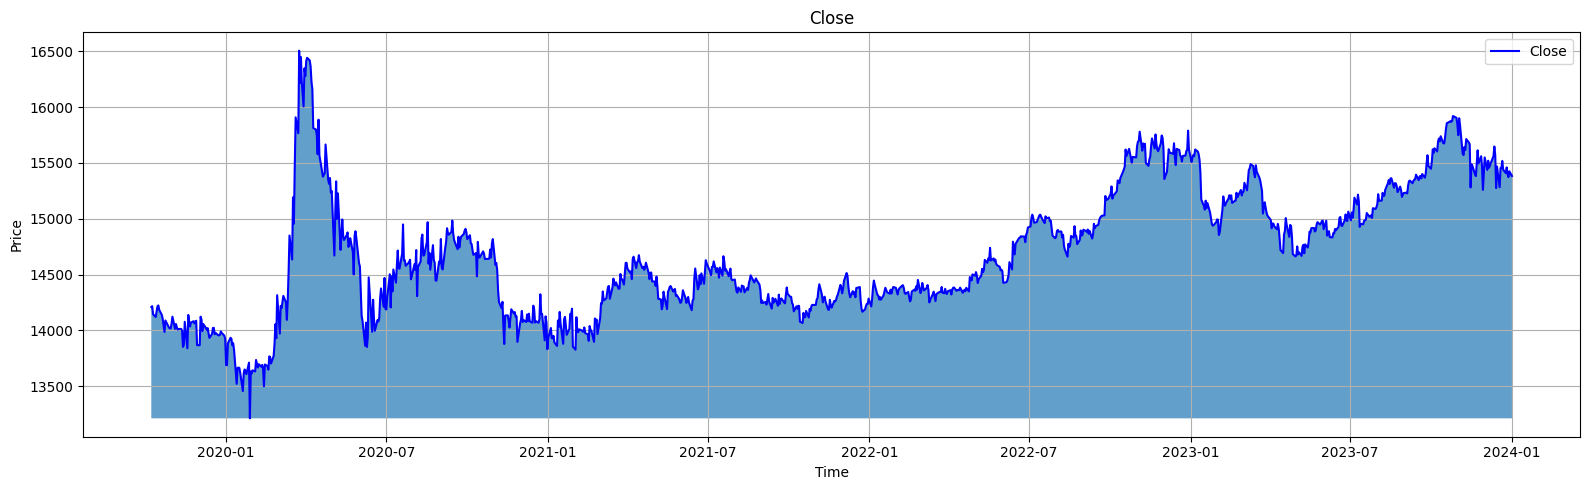

In [22]:
# plot train series
plot_series(train_series, ['Close'], fillbar=True)
# plot validation series
plot_series(valid_series, ['Close'], fillbar=True)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(np.expand_dims(train_series['Close'].to_numpy(), axis=-1))
valid_scaled = scaler.transform(np.expand_dims(valid_series['Close'].to_numpy(), axis=-1))

# Windowing Data Series
•	For the Original Series (idrx): If you’re not differencing the series, you might consider a larger window size to account for the strong autocorrelation seen in the ACF (e.g., a window size between 10 to 20).

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # series = tf.expand_dims(series, axis=-1)

  # create tf dataset
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # windowed dataset as window size
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

  # flat the window
  dataset = dataset.flat_map(lambda window : window.batch(window_size+1))

  # shuffle the dataset
  dataest = dataset.shuffle(shuffle_buffer)

  # map the window to input and target value
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

  # batching the dataset and prefetch 1 data point
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [25]:
BATCH_SIZE = 8
WINDOW_SIZE = 30 # will be explore more and fine tuned the value
# WINDOW_SIZE_DIFF = 30 # will be explore more and fine tuned the value
SHUFFLE_BUFFER = len(train_series)

train_idrx = windowed_dataset(train_scaled, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)
valid_idrx = windowed_dataset(valid_scaled, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)

I0000 00:00:1745465274.234974      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [26]:
for j, data in enumerate(valid_idrx.take(2)):
  # Look up the 5 first training datasetes from batch 1 and 2
  print(f'\n\033[1mBATCH: {j}\033[0m '.ljust(50, '-'))
  for i in range(2):
    print(f'\033[32mseries\033[0m: {data[0][i].numpy().shape}\n\033[31mtarget\033[0m: {data[1][i].numpy().shape}')


BATCH: 0 --------------------------------
series: (30, 1)
target: (1, 1)
series: (30, 1)
target: (1, 1)

BATCH: 1 --------------------------------
series: (30, 1)
target: (1, 1)
series: (30, 1)
target: (1, 1)


# Build the model

In [27]:
# build network architecture

# defein rnn method to compare
LSTM_NET = LSTM(100, return_sequences=True, name='lstm_1')
GRU_NET = GRU(100, return_sequences=True, name='gru_1')

def build_temporal_network(rnn):
    input_l = Input(shape=(WINDOW_SIZE, 1))

    # LSTM Layer
    rnn = rnn(input_l)

    # CONV1D Layer
    conv1d = Conv1D(filters=80, kernel_size=10, name='con1d_1', strides=1, padding='causal')(rnn)

    # Pooling layer
    max_pool1d = MaxPooling1D(10, name='max_pool1d_1')(conv1d)

    # Flattened layer
    flattened_l = GlobalAveragePooling1D()(max_pool1d)

    # Dense layer
    dense = Dense(100, activation='relu', name='dense_1')(flattened_l)
    # dense = Dense(50, activation='relu', name='dense_2')(dense)
    output_l = Dense(1, name='output')(dense)

    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    return model


# build model
LR = 5e-5
MOMENTUM=0.9
METRICS = [tf.keras.losses.MeanAbsoluteError(name='mae')]
PLOT_MODEL = False
SUMMARY = True

def build_model(model, lr=LR, momentum=MOMENTUM, metrics=METRICS, plot_model=PLOT_MODEL, summary=SUMMARY):
    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum),
        metrics=metrics
    )

    if plot_model:
        tf.keras.utils.plot_model(model, to_file='model_graph.png', show_shapes=True)

    if summary:
        model.summary()

    return model


model_lstm = build_model(build_temporal_network(LSTM_NET))
model_gru = build_model(build_temporal_network(GRU_NET))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ con1d_1 (Conv1D)                     │ (None, 30, 80)              │          80,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 3, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 80)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,081 (504.22 KB)

 Trainable params: 129,081 (504.22 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 30, 100)             │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ con1d_1 (Conv1D)                     │ (None, 30, 80)              │          80,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 3, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 80)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,181 (465.55 KB)

 Trainable params: 119,181 (465.55 KB)

 Non-trainable params: 0 (0.00 B)

# Train The Model

In [28]:
# set Callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.1,
    patience=5,
    verbose=3,
    mode='min',
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.0001,
)

In [29]:
# Fit the model
history_lstm = model_lstm.fit(train_idrx,
                         epochs=50,
                         validation_data=valid_idrx,
                         batch_size=BATCH_SIZE, callbacks=[lr_reducer])


Epoch 1/50


I0000 00:00:1745404120.453497     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


    549/Unknown 6s 4ms/step - loss: 0.0198 - mae: 0.1504

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


549/549 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0198 - mae: 0.1506 - val_loss: 0.1874 - val_mae: 0.6039 - learning_rate: 5.0000e-05
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0083 - mae: 0.0947 - val_loss: 0.1019 - val_mae: 0.4433 - learning_rate: 5.0000e-05
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0126 - mae: 0.1453 - val_loss: 0.0669 - val_mae: 0.3575 - learning_rate: 5.0000e-05
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0153 - mae: 0.1650 - val_loss: 0.0496 - val_mae: 0.3066 - learning_rate: 5.0000e-05
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0154 - mae: 0.1665 - val_loss: 0.0392 - val_mae: 0.2717 - learning_rate: 5.0000e-05
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0142 - mae: 0.1603 - val_loss: 0.0318 - val_mae: 0.2437 - learning_rate: 5.0000e-05
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0126 - mae: 0.1509 - val_loss: 0.0259 - val_mae: 0.2191 - learning_rate: 

In [30]:
# Fit the model
history_gru = model_gru.fit(train_idrx,
                         epochs=50,
                         validation_data=valid_idrx,
                         batch_size=BATCH_SIZE, callbacks=[lr_reducer])


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0193 - mae: 0.1497 - val_loss: 0.1500 - val_mae: 0.5397 - learning_rate: 5.0000e-05
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0073 - mae: 0.0937 - val_loss: 0.0742 - val_mae: 0.3775 - learning_rate: 5.0000e-05
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0109 - mae: 0.1368 - val_loss: 0.0459 - val_mae: 0.2951 - learning_rate: 5.0000e-05
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0117 - mae: 0.1447 - val_loss: 0.0324 - val_mae: 0.2463 - learning_rate: 5.0000e-05
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0104 - mae: 0.1363 - val_loss: 0.0241 - val_mae: 0.2108 - learning_rate: 5.0000e-05
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0086 - mae: 0.1237 - val_loss: 0.0182 - val_mae: 0.1819 - learning_rate: 5.0000e-05
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070 - mae: 0.1113 - val_loss: 0.0140 - val_mae: 0.1580 - lear

In [31]:
model_lstm.save("lstm_01.keras")
model_gru.save("gru_01.keras")

In [32]:
def compare_forecast_on_df(history, series, windowed_series, save_csv: str = None):
    forecast = history.model.predict(windowed_series)
    forecast = scaler.inverse_transform(forecast)
    
    forecast_df = pd.DataFrame(series['Close'][WINDOW_SIZE:])
    forecast_df['Close_Forecast'] = forecast

    if save_csv != None:
        forecast_df.to_csv(save_csv)
    return forecast_df

In [33]:
forecast_lstm_train_df = compare_forecast_on_df(history_lstm, train_series, train_idrx, save_csv='train_forecast_lstm.csv')
forecast_lstm_valid_df = compare_forecast_on_df(history_lstm, valid_series, valid_idrx, save_csv='valid_forecast_lstm.csv')

forecast_gru_train_df = compare_forecast_on_df(history_gru, train_series, train_idrx, save_csv='train_forecast_gru.csv')
forecast_gru_valid_df = compare_forecast_on_df(history_gru, valid_series, valid_idrx, save_csv='valid_forecast_gru.csv')

display(forecast_lstm_train_df)
display(forecast_lstm_valid_df)

display(forecast_gru_train_df)
display(forecast_gru_valid_df)

549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


,Close,Close_Forecast
2002-02-13,10188.0,10434.597656
2002-02-14,10230.0,10429.889648
2002-02-15,10247.0,10426.434570
2002-02-18,10235.0,10420.099609
2002-02-19,10185.0,10415.013672
...,...,...
2019-10-01,14206.0,14171.965820
2019-10-02,14188.0,14164.600586
2019-10-03,14166.0,14159.826172
2019-10-06,14128.0,14156.176758


,Close,Close_Forecast
2019-11-20,14083.000000,14098.756836
2019-11-21,14035.278320,14090.674805
2019-11-22,14070.000000,14082.202148
2019-11-25,14083.011719,14075.972656
2019-11-26,14063.748047,14070.996094
...,...,...
2023-12-26,15460.000000,15264.811523
2023-12-27,15400.000000,15259.570312
2023-12-28,15373.000000,15267.033203
2023-12-29,15425.000000,15265.692383


,Close,Close_Forecast
2002-02-13,10188.0,10424.670898
2002-02-14,10230.0,10418.391602
2002-02-15,10247.0,10414.430664
2002-02-18,10235.0,10408.183594
2002-02-19,10185.0,10404.152344
...,...,...
2019-10-01,14206.0,14171.517578
2019-10-02,14188.0,14167.008789
2019-10-03,14166.0,14164.359375
2019-10-06,14128.0,14161.559570


,Close,Close_Forecast
2019-11-20,14083.000000,14094.299805
2019-11-21,14035.278320,14087.001953
2019-11-22,14070.000000,14078.065430
2019-11-25,14083.011719,14073.022461
2019-11-26,14063.748047,14068.960938
...,...,...
2023-12-26,15460.000000,15183.462891
2023-12-27,15400.000000,15177.209961
2023-12-28,15373.000000,15181.096680
2023-12-29,15425.000000,15177.787109


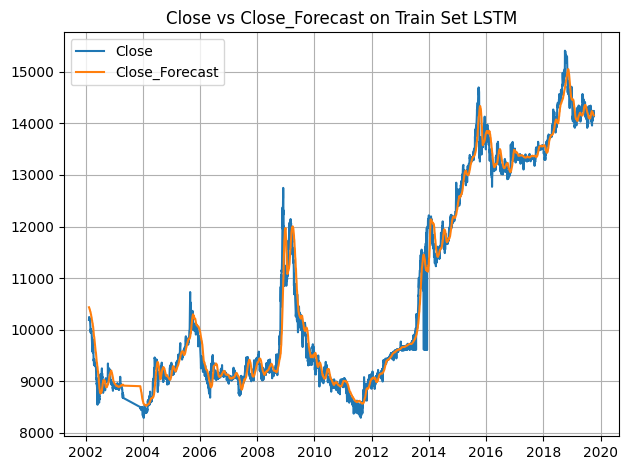

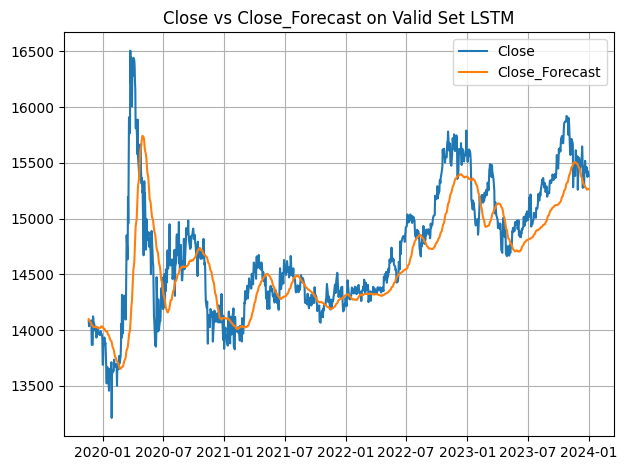

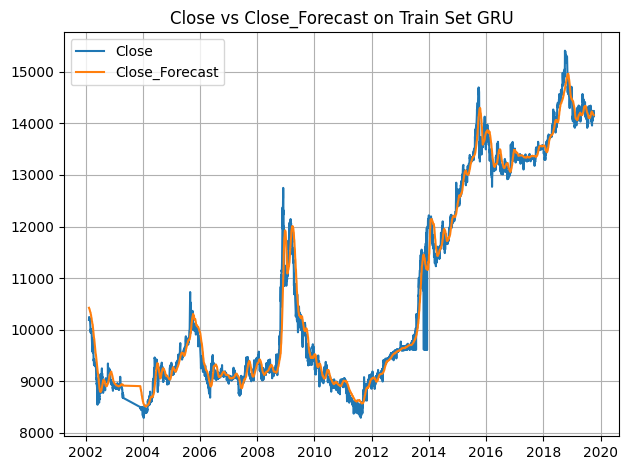

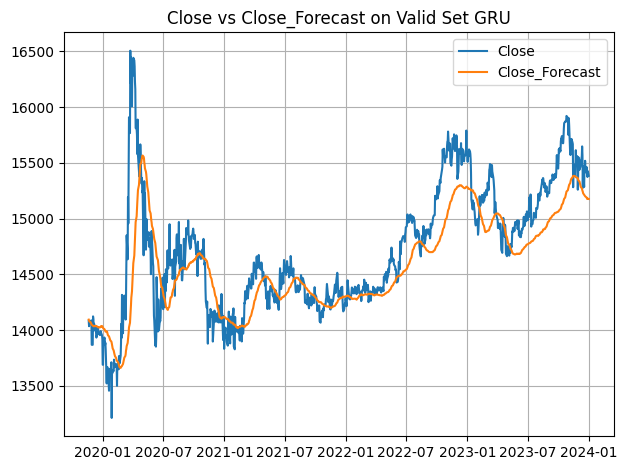

In [34]:
plot_compare(forecast_lstm_train_df, list(forecast_lstm_train_df.columns), title='Close vs Close_Forecast on Train Set LSTM', save_fig='close_vs_close_forecast_train_set_lstm.png')
plot_compare(forecast_lstm_valid_df, list(forecast_lstm_valid_df.columns), title='Close vs Close_Forecast on Valid Set LSTM', save_fig='close_vs_close_forecast_valid_set_lstm.png')

plot_compare(forecast_gru_train_df, list(forecast_gru_train_df.columns), title='Close vs Close_Forecast on Train Set GRU', save_fig='close_vs_close_forecast_train_set_gru.png')
plot_compare(forecast_gru_valid_df, list(forecast_gru_valid_df.columns), title='Close vs Close_Forecast on Valid Set GRU', save_fig='close_vs_close_forecast_valid_set_gru.png')

# Hyperparameters Tuning with Keras Tuner

In [35]:
class TemporalHyperModel(keras_tuner.HyperModel):
    def __init__(self, key):
        self.key = key

    
    def build_temporal_network(self, key, units, c_filters, lr, dropout):
        input_l = Input(shape=(WINDOW_SIZE, 1))
    
        # RNN Layer
        if key == 'lstm':
            rnn = LSTM(units, return_sequences=True, name='lstm_1')(input_l)
        elif key == 'gru':
            rnn = GRU(units, return_sequences=True, name='gru_1')(input_l)
        else:
            raise NameError("key is str, the value must be either 'lstm' or 'gru'")
    
        # CONV1D Layer
        conv1d = Conv1D(filters=c_filters, kernel_size=7, name='conf1d_1', strides=1, padding='causal')(rnn)
    
        # Pooling layer
        max_pool1d = MaxPooling1D(10, name='max_pool1d_1')(conv1d)
    
        # Flattened layer
        flattened_l = GlobalAveragePooling1D()(max_pool1d)
    
        # add dropout if necessary
        if dropout:
            flattened_l = Dropout(0.25)(flattened_l)
    
        # Dense layer
        dense = Dense(units, activation='relu', name='dense_1')(flattened_l)
    
        output_l = Dense(1, name='output')(dense)
    
        model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
        model.compile(
            loss=tf.keras.losses.Huber(),
            optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
            metrics=[tf.keras.losses.MeanAbsoluteError(name='mae')]
        )
        
        return model


    def build(self, hp):
        rnn_key = self.key
        units = hp.Int('units', min_value=50, max_value=200, step=50)
        c_filters = hp.Int('c_filters', min_value=50, max_value=100, step=25)
        lr = hp.Choice('lr', [5e-5, 5e-4])
        dropout = hp.Boolean("dropout")
        
        model = self.build_temporal_network(rnn_key, units, c_filters, lr, dropout)
        return model

In [37]:
model_lstm_tuner = TemporalHyperModel(key='lstm')
model_gru_tuner = TemporalHyperModel(key='gru')

## Keras Tuner

In [38]:
lstm_tuner = keras_tuner.GridSearch(
    hypermodel=TemporalHyperModel('lstm'),
    objective=keras_tuner.Objective('val_mae', direction='min'),
    max_trials=None,
    executions_per_trial=1,
    overwrite=False,
    directory="lstm_tuner",
    project_name="usdidr_prediction_bayes_lstm_11",
)

gru_tuner = keras_tuner.GridSearch(
    hypermodel=TemporalHyperModel('gru'),
    objective=keras_tuner.Objective('val_mae', direction='min'),
    max_trials=None,
    executions_per_trial=1,
    overwrite=False,
    directory="gru_tuner",
    project_name="usdidr_prediction_bayes_gru_11",
)

In [39]:
lstm_tuner.search_space_summary()
gru_tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
c_filters (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 25, 'sampling': 'linear'}
lr (Choice)
{'default': 5e-05, 'conditions': [], 'values': [5e-05, 0.0005], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
c_filters (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 25, 'sampling': 'linear'}
lr (Choice)
{'default': 5e-05, 'conditions': [], 'values': [5e-05, 0.0005], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}


### **Start Tuning**

In [100]:
# @title LSTM model Tuning
lstm_tuner.search(train_idrx, epochs=10, validation_data=valid_idrx)

Trial 48 Complete [00h 00m 31s]
val_mae: 0.03094034641981125

Best val_mae So Far: 0.03094034641981125
Total elapsed time: 00h 24m 27s


In [40]:
# @title GRU model Tuning
gru_tuner.search(train_idrx, epochs=10, validation_data=valid_idrx)

Trial 48 Complete [00h 00m 31s]
val_mae: 0.029882483184337616

Best val_mae So Far: 0.02877134084701538
Total elapsed time: 00h 23m 43s


### **End Tuning**

In [42]:
# lstm_tuner.results_summary()
gru_tuner.results_summary()

Results summary
Results in gru_tuner/usdidr_prediction_bayes_gru_11
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0019 summary
Hyperparameters:
units: 100
c_filters: 75
lr: 0.0005
dropout: True
Score: 0.02877134084701538

Trial 0003 summary
Hyperparameters:
units: 50
c_filters: 50
lr: 0.0005
dropout: True
Score: 0.029603254050016403

Trial 0047 summary
Hyperparameters:
units: 200
c_filters: 100
lr: 0.0005
dropout: True
Score: 0.029882483184337616

Trial 0011 summary
Hyperparameters:
units: 50
c_filters: 100
lr: 0.0005
dropout: True
Score: 0.029936302453279495

Trial 0031 summary
Hyperparameters:
units: 150
c_filters: 75
lr: 0.0005
dropout: True
Score: 0.030055411159992218

Trial 0006 summary
Hyperparameters:
units: 50
c_filters: 75
lr: 0.0005
dropout: False
Score: 0.030241748318076134

Trial 0043 summary
Hyperparameters:
units: 200
c_filters: 75
lr: 0.0005
dropout: True
Score: 0.030386939644813538

Trial 0023 summary
Hyperparameters:
units: 100
c_filters: 100

In [43]:
# lstm_models = lstm_tuner.get_best_models(num_models=1)
gru_models = gru_tuner.get_best_models(num_models=1)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 11 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [44]:
# best_lstm_model = lstm_models[0]
best_gru_model = gru_models[0]

In [ ]:
best_lstm_model.summary()

In [45]:
best_gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 30, 100)             │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 30, 75)              │          52,575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 3, 75)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 75)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,176 (356.16 KB)

 Trainable params: 91,176 (356.16 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# best_lstm_model.save('best_model_tuned_bayes_lstm_10.keras')
best_gru_model.save('best_model_tuned_bayes_gru_10.keras')

## End of keras tuning (be careful to run the code above)

# Train the model

In [ ]:
best_lstm_hps = lstm_tuner.get_best_hyperparameters(5)
for hp in best_lstm_hps:
  print(hp.values)

In [47]:
best_gru_hps = gru_tuner.get_best_hyperparameters(5)
for hp in best_gru_hps:
  print(hp.values)

{'units': 100, 'c_filters': 75, 'lr': 0.0005, 'dropout': True}
{'units': 50, 'c_filters': 50, 'lr': 0.0005, 'dropout': True}
{'units': 200, 'c_filters': 100, 'lr': 0.0005, 'dropout': True}
{'units': 50, 'c_filters': 100, 'lr': 0.0005, 'dropout': True}
{'units': 150, 'c_filters': 75, 'lr': 0.0005, 'dropout': True}


In [52]:
# Build the model with the best hp.
# best_lstm_model = model_lstm_tuner(best_lstm_hps[0], key='lstm')
# best_gru_model = model_lstm_tuner(best_gru_hps[0], key='gru')
tf.keras.config.enable_unsafe_deserialization()


best_lstm_model = tf.keras.models.load_model('/kaggle/input/idrx_models/keras/default/1/best_model_tuned_bayes_lstm_10.keras')
best_lstm_model.summary()

best_gru_model = tf.keras.models.load_model('/kaggle/input/idrx_models/keras/default/1/best_model_tuned_bayes_gru_10.keras')
best_gru_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 11 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 30, 75)              │          78,825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 3, 75)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 75)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,154 (1.39 MB)

 Trainable params: 181,576 (709.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 181,578 (709.29 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 30, 100)             │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 30, 75)              │          52,575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 3, 75)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 75)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,354 (712.32 KB)

 Trainable params: 91,176 (356.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,178 (356.17 KB)

In [53]:
# @title Set Callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.1,
    patience=5,
    verbose=3,
    mode='min',
    min_delta=1e-7,
    cooldown=0,
    min_lr=0.0001,
)

In [54]:
# @title Fit LSTM the model
history_tuned_lstm = best_lstm_model.fit(
    train_idrx,
    epochs=50,
    validation_data=valid_idrx,
    batch_size=BATCH_SIZE,
    callbacks=[lr_reducer]
)

Epoch 1/50
    547/Unknown 4s 4ms/step - loss: 0.0012 - mae: 0.0355

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0012 - mae: 0.0355 - val_loss: 0.0011 - val_mae: 0.0315 - learning_rate: 5.0000e-04
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0012 - mae: 0.0349 - val_loss: 0.0011 - val_mae: 0.0311 - learning_rate: 5.0000e-04
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0340 - val_loss: 0.0011 - val_mae: 0.0310 - learning_rate: 5.0000e-04
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0343 - val_loss: 0.0011 - val_mae: 0.0310 - learning_rate: 5.0000e-04
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0347 - val_loss: 0.0011 - val_mae: 0.0314 - learning_rate: 5.0000e-04
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0345 - val_loss: 0.0011 - val_mae: 0.0309 - learning_rate: 5.0000e-04
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0012 - mae: 0.0349 - val_loss: 0.0011 - val_mae: 0.0308 - learning_rate: 

In [31]:
# @title Fit GRU the model
history_tuned_gru = best_gru_model.fit(
    train_idrx,
    epochs=50,
    validation_data=valid_idrx,
    batch_size=BATCH_SIZE,
    callbacks=[lr_reducer]
)

Epoch 1/50


I0000 00:00:1745465533.306179     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


    549/Unknown 6s 4ms/step - loss: 0.0012 - mae: 0.0348

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


549/549 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0012 - mae: 0.0348 - val_loss: 9.8350e-04 - val_mae: 0.0287 - learning_rate: 5.0000e-04
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0342 - val_loss: 0.0010 - val_mae: 0.0292 - learning_rate: 5.0000e-04
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0010 - mae: 0.0331 - val_loss: 9.8269e-04 - val_mae: 0.0286 - learning_rate: 5.0000e-04
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0338 - val_loss: 9.9290e-04 - val_mae: 0.0286 - learning_rate: 5.0000e-04
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0339 - val_loss: 0.0010 - val_mae: 0.0292 - learning_rate: 5.0000e-04
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0010 - mae: 0.0330 - val_loss: 0.0010 - val_mae: 0.0295 - learning_rate: 5.0000e-04
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0010 - mae: 0.0333 - val_loss: 9.9474e-04 - val_mae: 0.0287 -

In [35]:
def plot_history(history):
  params = [keys for keys in history.history.keys()]
  print(params)
  epochs = range(len(history.history['loss']))

  ncols = 2
  nrows= len(params)//ncols//2
  fig, axs = plt.subplots(figsize=(16, 5*nrows), ncols=ncols, nrows=nrows)
  axs = axs.flatten()

  # Iterate over axses objects in the grid
   # Access and iterate over individual axses in the grid
  for i, param in enumerate(list(params)):
    if 'val' not in param:
      axs[i].set_title(param)
      axs[i].plot(epochs, history.history[f'val_{param}'], label=f'val_{param}')
      axs[i].set_title(param)
      axs[i].plot(epochs, history.history[param], label=param)

      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel('Loss')
      axs[i].grid(True)
      axs[i].legend()

  plt.show()

['loss', 'mae', 'val_loss', 'val_mae', 'learning_rate']


IndexError: index 4 is out of bounds for axis 0 with size 2

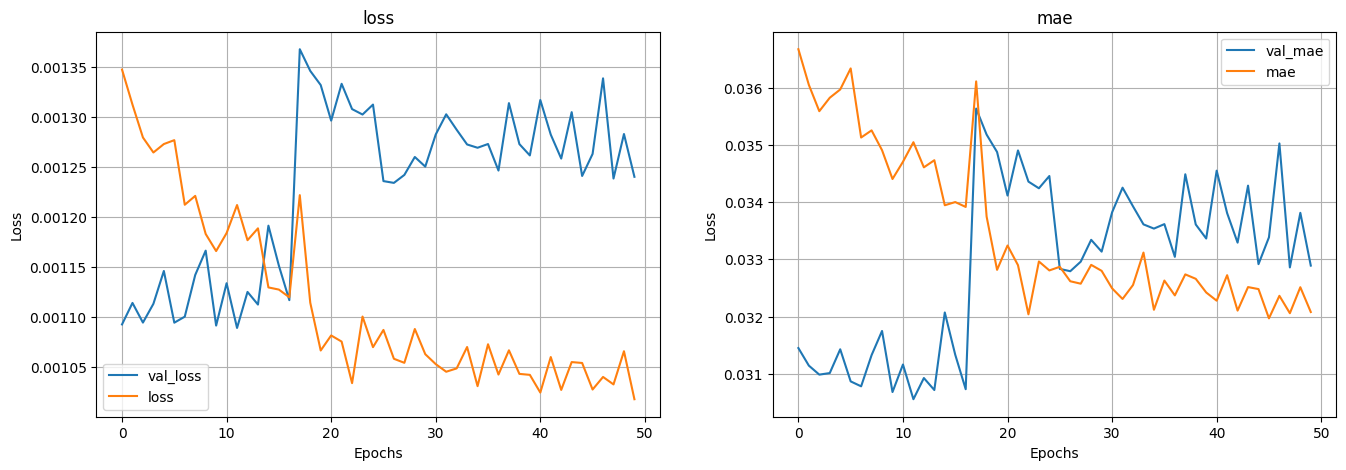

In [57]:
# @title Learning History of LSTM and GRU
plot_history(history_tuned_lstm)

['loss', 'mae', 'val_loss', 'val_mae', 'learning_rate']


IndexError: index 4 is out of bounds for axis 0 with size 2

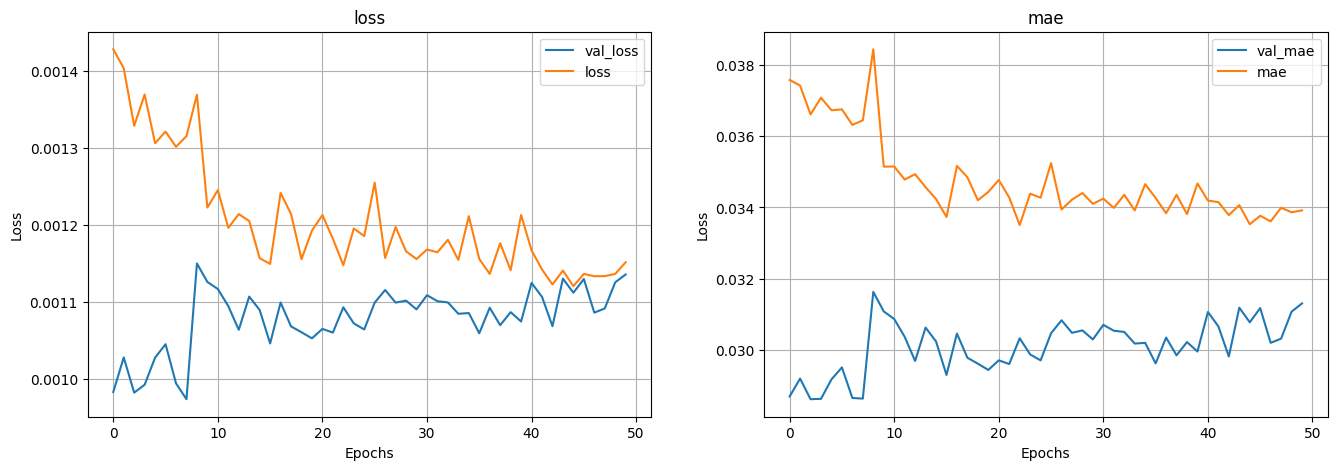

In [58]:
plot_history(history_tuned_gru)

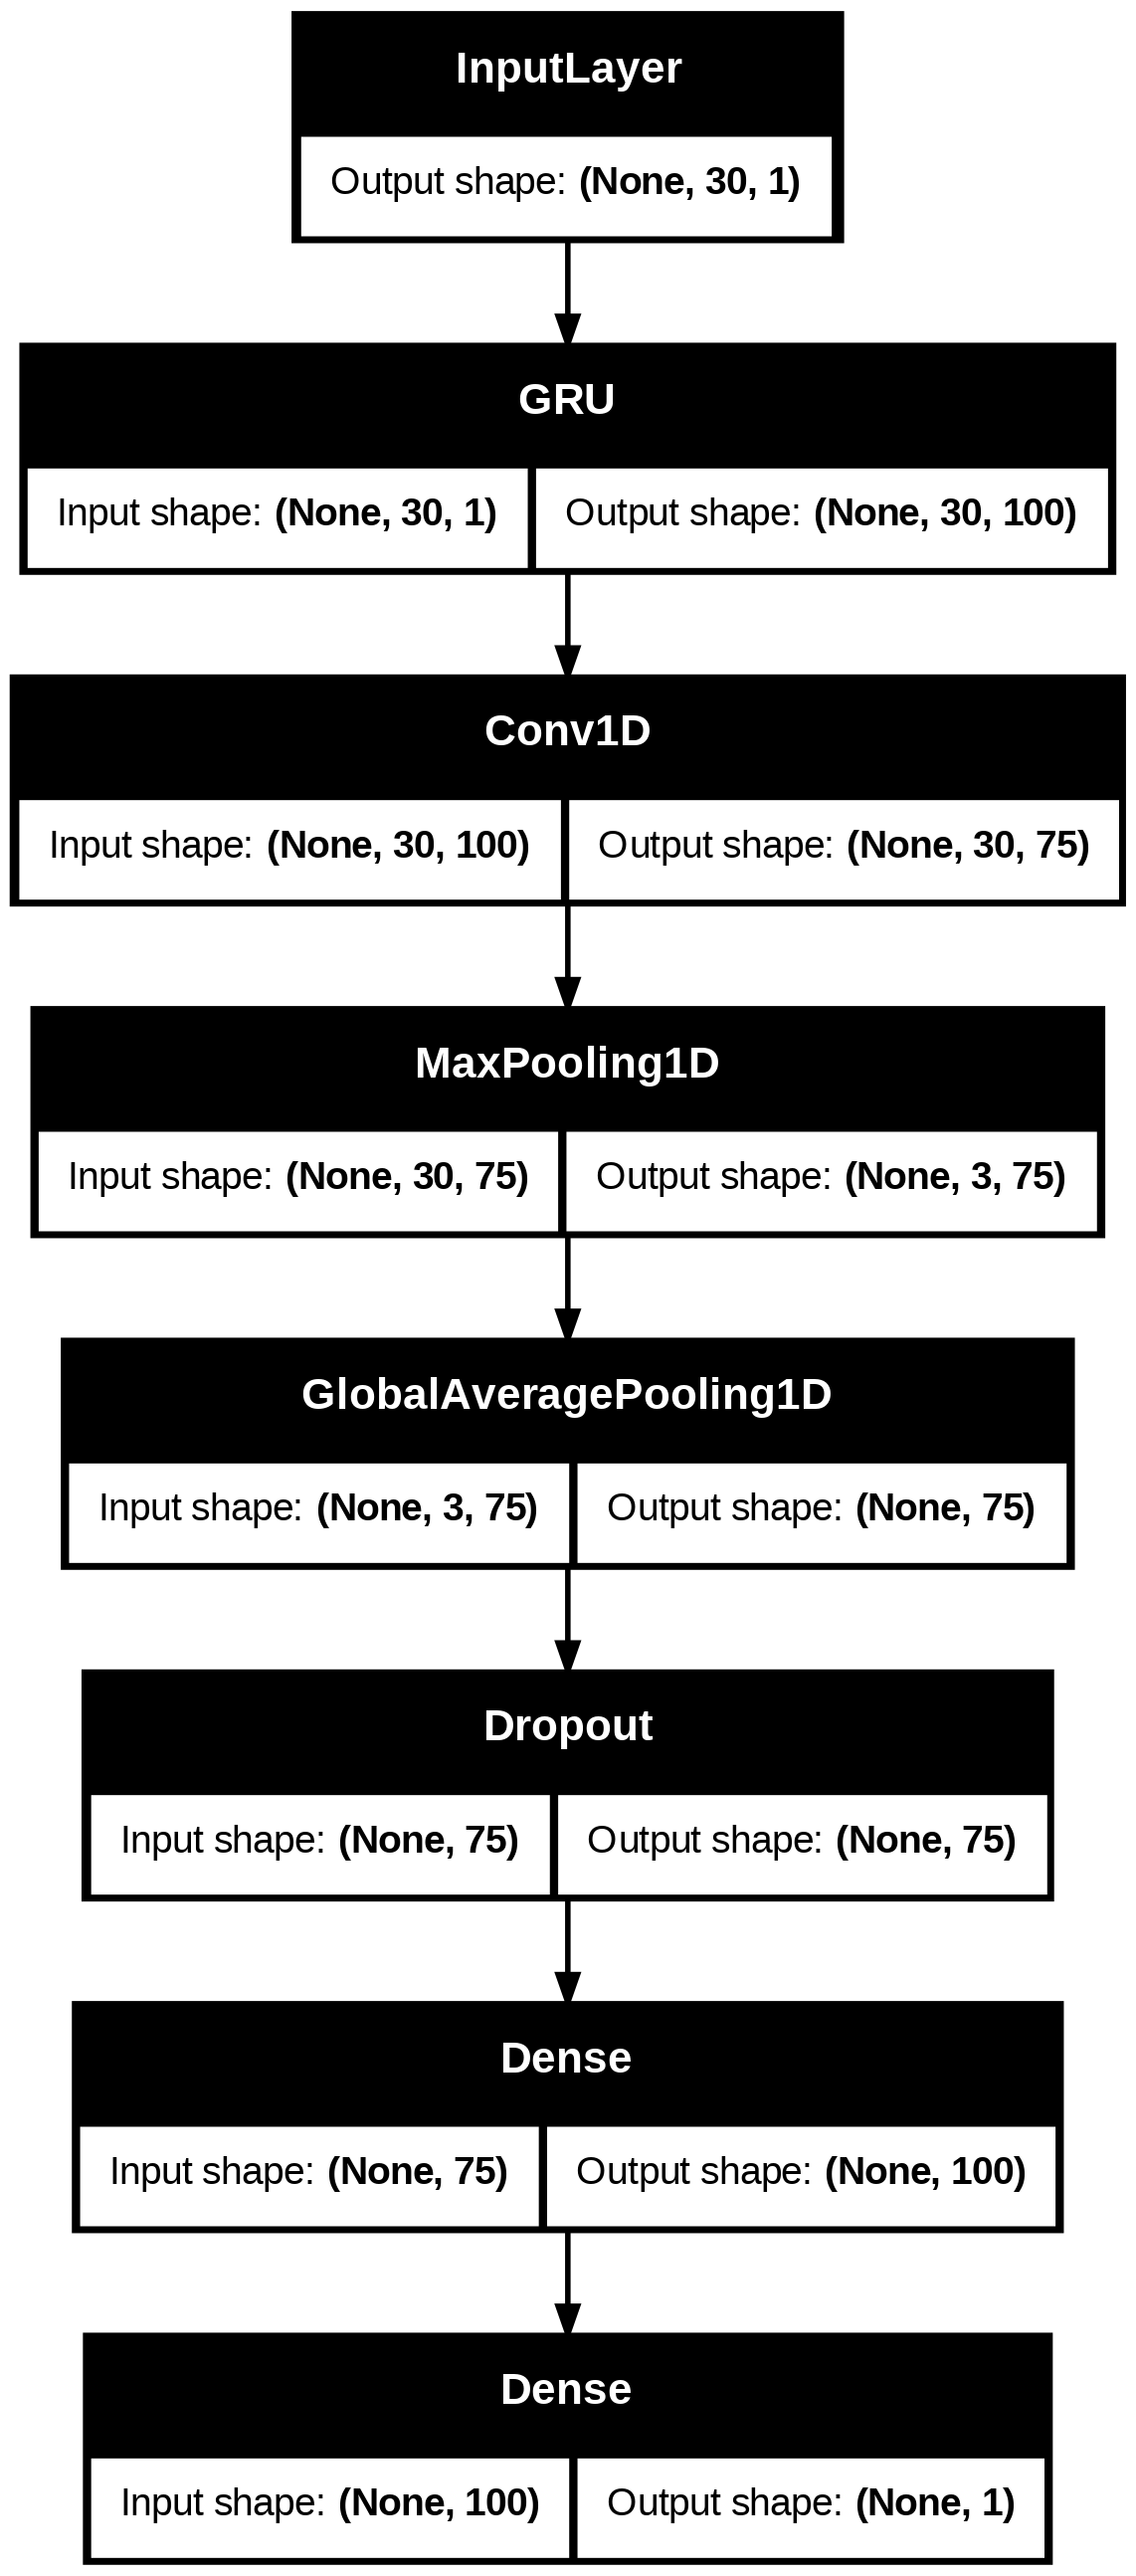

In [59]:
best_lstm_model.save('best_lstm_model_hp_trained_10.keras')
tf.keras.utils.plot_model(best_lstm_model, to_file='model_graph_lstm_tuned.png', show_shapes=True)

best_gru_model.save('best_gru_model_tuned_bayes_trained_10.keras')
tf.keras.utils.plot_model(best_gru_model, to_file='model_graph_gru_tuned.png', show_shapes=True)

## Inference on Dataset

In [60]:
def compare_forecast_on_df(history, series, windowed_series, save_csv: str = None):
    forecast = history.model.predict(windowed_series)
    forecast = scaler.inverse_transform(forecast)
    
    forecast_df = pd.DataFrame(series['Close'][WINDOW_SIZE:])
    forecast_df['Close_Forecast'] = forecast

    if save_csv != None:
        forecast_df.to_csv(save_csv)
    return forecast_df

In [61]:
forecast_tuned_lstm_train_df = compare_forecast_on_df(history_tuned_lstm, train_series, train_idrx, save_csv='train_forecast_tuned_lstm.csv')
forecast_tuned_lstm_valid_df = compare_forecast_on_df(history_tuned_lstm, valid_series, valid_idrx, save_csv='valid_forecast_tuned_lstm.csv')

forecast_tuned_gru_train_df = compare_forecast_on_df(history_tuned_gru, train_series, train_idrx, save_csv='train_forecast_tuned_gru.csv')
forecast_tuned_gru_valid_df = compare_forecast_on_df(history_tuned_gru, valid_series, valid_idrx, save_csv='valid_forecast_tuned_gru.csv')

display(forecast_tuned_lstm_train_df)
display(forecast_tuned_lstm_valid_df)

display(forecast_tuned_gru_train_df)
display(forecast_tuned_gru_valid_df)

549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
     51/Unknown 0s 2ms/step

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


,Close,Close_Forecast
2002-02-13,10188.0,10444.885742
2002-02-14,10230.0,10438.407227
2002-02-15,10247.0,10433.098633
2002-02-18,10235.0,10425.052734
2002-02-19,10185.0,10418.614258
...,...,...
2019-10-01,14206.0,14140.987305
2019-10-02,14188.0,14136.932617
2019-10-03,14166.0,14133.625977
2019-10-06,14128.0,14131.906250


,Close,Close_Forecast
2019-11-20,14083.000000,14065.828125
2019-11-21,14035.278320,14060.117188
2019-11-22,14070.000000,14052.778320
2019-11-25,14083.011719,14048.571289
2019-11-26,14063.748047,14043.674805
...,...,...
2023-12-26,15460.000000,15241.104492
2023-12-27,15400.000000,15239.004883
2023-12-28,15373.000000,15243.611328
2023-12-29,15425.000000,15242.540039


,Close,Close_Forecast
2002-02-13,10188.0,10385.434570
2002-02-14,10230.0,10377.041016
2002-02-15,10247.0,10370.875000
2002-02-18,10235.0,10361.896484
2002-02-19,10185.0,10355.209961
...,...,...
2019-10-01,14206.0,14124.177734
2019-10-02,14188.0,14123.409180
2019-10-03,14166.0,14123.448242
2019-10-06,14128.0,14117.956055


,Close,Close_Forecast
2019-11-20,14083.000000,14048.341797
2019-11-21,14035.278320,14042.860352
2019-11-22,14070.000000,14035.170898
2019-11-25,14083.011719,14027.602539
2019-11-26,14063.748047,14021.150391
...,...,...
2023-12-26,15460.000000,15265.750000
2023-12-27,15400.000000,15259.449219
2023-12-28,15373.000000,15263.751953
2023-12-29,15425.000000,15262.158203


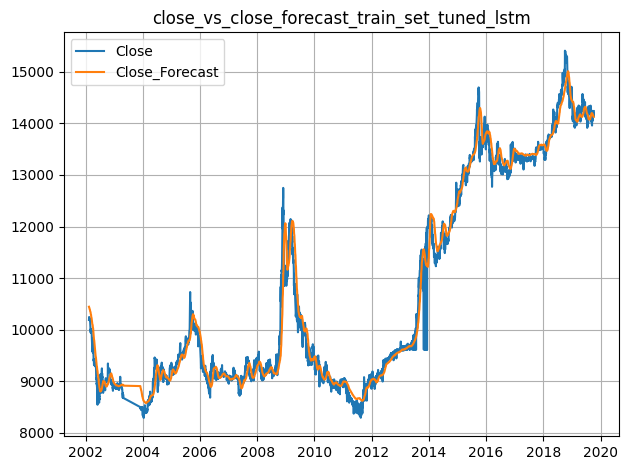

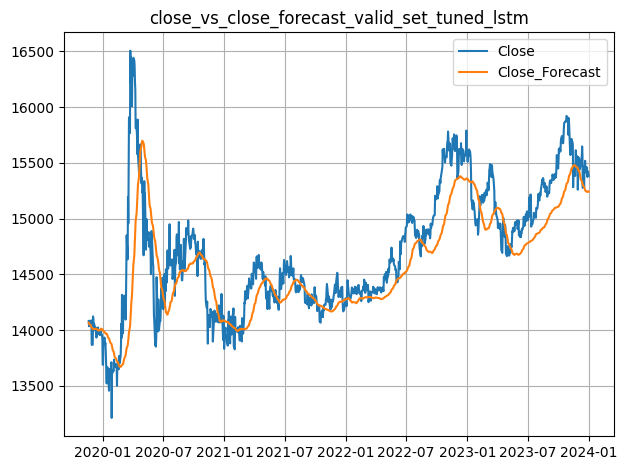

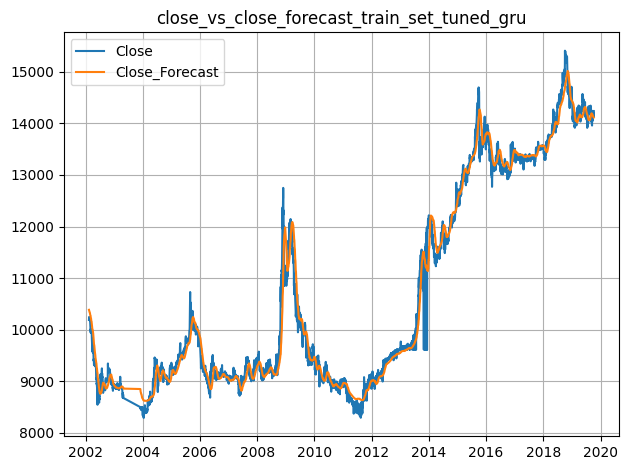

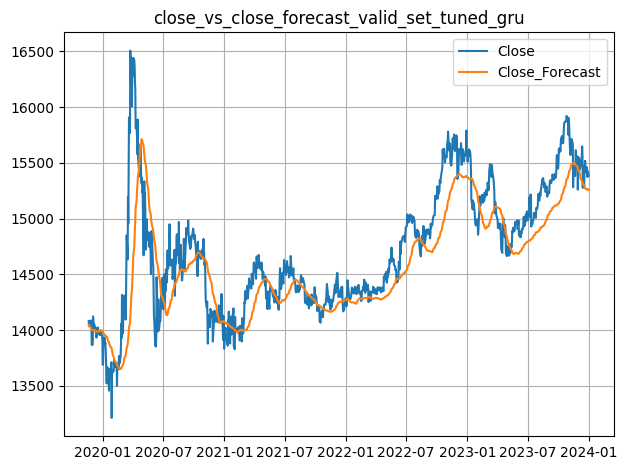

In [64]:
# @title Plot comparison trained forecast value on train set and valid set

plot_compare(forecast_tuned_lstm_train_df, forecast_tuned_lstm_train_df.columns, title='close_vs_close_forecast_train_set_tuned_lstm', save_fig='close_vs_close_forecast_train_set_tuned_lstm.png')
plot_compare(forecast_tuned_lstm_valid_df, forecast_tuned_lstm_valid_df.columns, title='close_vs_close_forecast_valid_set_tuned_lstm', save_fig='close_vs_close_forecast_valid_set_tuned_lstm.png')

plot_compare(forecast_tuned_gru_train_df, forecast_tuned_gru_train_df.columns, title='close_vs_close_forecast_train_set_tuned_gru', save_fig='close_vs_close_forecast_train_set_tuned_gru.png')
plot_compare(forecast_tuned_gru_valid_df, forecast_tuned_gru_valid_df.columns, title='close_vs_close_forecast_valid_set_tuned_gru', save_fig='close_vs_close_forecast_valid_set_tuned_gru.png')